In [70]:
import pandas as pd
import redditcleaner
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.metrics import accuracy_score
pd.set_option("display.max_colwidth", None)
import warnings
warnings.filterwarnings('ignore') # Ensuring the notebook remains tidy

# Read files

In [2]:
yoga_df = pd.read_csv('yoga_submissions.csv')
meditation_df = pd.read_csv('meditation_submissions.csv')
yoga_df.shape, meditation_df.shape

((1500, 81), (1500, 86))

In [3]:
meditation_df.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subre

In [4]:
# Choose columns of interest
columns = ['subreddit', 'title', 'selftext', 'is_self', 'num_comments','created_utc', 'created','removed_by_category',
         'banned_by', 'author', 'url', 'score', 'upvote_ratio']

In [5]:
combined = meditation_df[columns].append(yoga_df[columns], ignore_index=True) # merging datasets and resetting index
print(combined.shape)
combined.head()

(3000, 13)


subreddit  \
0  Meditation   
1  Meditation   
2  Meditation   
3  Meditation   
4  Meditation   

                                                                                                                                                                                         title  \
0  Massive announcement concerning the future of the human species of this planet! Please listen and see for yourself later when I post more. Namaste. Love. Peace. Goodwill. The time is now!   
1  Technique for Meditating                                                                                                                                                                      
2  Heres some meditation music                                                                                                                                                                   
3  Meditation Technique to deal with the first minutes with a noisy mind                                                                                                                         
4  Instant Relief from Stress and Insomnia, Stop All Stress - Calm Down, Anxiety Attacks, Sleep Music !                                                                                          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# Cleaning Part I - Remove irrelevant submissions
## Drop removed posts

In [6]:
combined.loc[combined['removed_by_category'].notnull()].head()

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio
1,Meditation,Technique for Meditating,[removed],True,1,1640905447,2021-12-31 07:04:07,moderator,NaN,saad2607,https://www.reddit.com/r/Meditation/comments/rsew0p/technique_for_meditating/,1,1.0
2,Meditation,Heres some meditation music,NaN,False,1,1640905432,2021-12-31 07:03:52,moderator,NaN,dshep9729,https://www.youtube.com/watch?v=Ll2VKjJ-B4g,1,1.0
4,Meditation,"Instant Relief from Stress and Insomnia, Stop All Stress - Calm Down, Anxiety Attacks, Sleep Music !",NaN,False,1,1640902313,2021-12-31 06:11:53,moderator,NaN,Alina_1981,https://youtu.be/wi0F3t4464U,1,1.0
5,Meditation,"New to Meditation, any tips?",[removed],True,1,1640902306,2021-12-31 06:11:46,moderator,NaN,mystic1846,https://www.reddit.com/r/Meditation/comments/rsdpsn/new_to_meditation_any_tips/,1,1.0
6,Meditation,Would spirit be limited by anything within Itself?,[removed],True,1,1640899565,2021-12-31 05:26:05,moderator,NaN,Vivid_Transition_91,https://www.reddit.com/r/Meditation/comments/rscnzn/would_spirit_be_limited_by_anything_within_itself/,1,1.0


In [71]:
combined.loc[combined['banned_by'].notnull()].head()

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio
928,Meditation,"Drop a few links of the current meditation/manifestation technics you're using, I am using this free one (the link attached to this post) but I want to see what everybody else is using.",NaN,True,1,1639368753,2021-12-13 12:12:33,deleted,moderators,[deleted],https://www.reddit.com/r/Meditation/comments/rf6t42/drop_a_few_links_of_the_current/,1,1.0
962,Meditation,I need your opinion on the Mental Health app I am developing,NaN,True,1,1639332810,2021-12-13 02:13:30,deleted,moderators,[deleted],https://www.reddit.com/r/Meditation/comments/reuo66/i_need_your_opinion_on_the_mental_health_app_i_am/,1,1.0
1137,Meditation,I'm looking for a meditation practice to use while under intense physical discomfort/pain,NaN,True,1,1639017062,2021-12-09 10:31:02,deleted,moderators,[deleted],https://www.reddit.com/r/Meditation/comments/rc7hds/im_looking_for_a_meditation_practice_to_use_while/,1,1.0
2115,yoga,I’m in search of an honest cub dm if you are interested ❤️❤️❤️,NaN,True,0,1638940496,2021-12-08 13:14:56,deleted,moderators,[deleted],https://www.reddit.com/r/yoga/comments/rbjhte/im_in_search_of_an_honest_cub_dm_if_you_are/,1,1.0


Since the banned authors have already been deleted under the 'removed_by_category', we can drop based on the 'removed_by_category' alone.

In [8]:
combined['removed_by_category'].value_counts()

moderator           659
reddit              257
automod_filtered    106
deleted             30 
Name: removed_by_category, dtype: int64

In [9]:
print('Total posts removed by Reddit: ' + str(combined.loc[combined['removed_by_category'].notnull()].shape[0]))
combined_approved = combined[combined.removed_by_category.isnull()]
print('Total posts remaining: ' + str(combined_approved.shape[0]))

Total posts removed by Reddit: 1052
Total posts remaining: 1948


In [10]:
combined_approved.loc[combined_approved['title'].isna() == True]

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio


## Posts with missing text will be removed
Determined by the 'is_self' boolean

In [11]:
combined_w_text = combined_approved[combined_approved['is_self'] == True]

In [12]:
combined_w_text

subreddit  \
0     Meditation   
3     Meditation   
7     Meditation   
9     Meditation   
10    Meditation   
...          ...   
2987  yoga         
2988  yoga         
2989  yoga         
2990  yoga         
2999  yoga         

                                                                                                                                                                                            title  \
0     Massive announcement concerning the future of the human species of this planet! Please listen and see for yourself later when I post more. Namaste. Love. Peace. Goodwill. The time is now!   
3     Meditation Technique to deal with the first minutes with a noisy mind                                                                                                                         
7     What should I focus on if I’m meditating without a video guide?                                                                                                                               
9     Racing mind, adhd?                                                                                                                                                                            
10    Is there such a thing as “spiritual meditation” vs just “meditation “                                                                                                                         
...                                                                     ...                                                                                                                         
2987  Can anyone recommend more yoga videos like Sara Ivanhoe’s ‘Yoga on the Edge?’                                                                                                                 
2988  Yoga props in Rishikesh?                                                                                                                                                                      
2989  Recommendations for quality yoga clothes and mat in the UK?                                                                                                                                   
2990  Yoga bag recs                                                                                                                                                                                 
2999  Can yoga help with anxiety?                                                                                                                                                                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [13]:
combined_w_text.loc[combined_w_text['selftext'].isna()]

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio
725,Meditation,Live Group Meditation with Will Cady 🧘🏻‍♀️,NaN,True,0,1639684380,2021-12-17 03:53:00,NaN,NaN,3DimenZ,https://www.reddit.com/r/Meditation/comments/rhyn1e/live_group_meditation_with_will_cady/,1,1.00
1542,yoga,"Anyone else struggle with not wanting to do yoga, even though they love it?",NaN,True,0,1640791482,2021-12-29 23:24:42,NaN,NaN,ilovemycatvader,https://www.reddit.com/r/yoga/comments/rrambg/anyone_else_struggle_with_not_wanting_to_do_yoga/,1,1.00
1571,yoga,Finally did it! Completed first day of yoga with Adriene. She says to do this beginners yoga for one week. Where do I go after that? Any and all suggestions. I do like her a lot so not against sticking with her. Advice?,NaN,True,0,1640712725,2021-12-29 01:32:05,NaN,NaN,betterday9,https://www.reddit.com/r/yoga/comments/rql02u/finally_did_it_completed_first_day_of_yoga_with/,1,1.00
1584,yoga,Anyone have yoga help with somatic memories?,NaN,True,0,1640664608,2021-12-28 12:10:08,NaN,NaN,infusedpineapple,https://www.reddit.com/r/yoga/comments/rq6c57/anyone_have_yoga_help_with_somatic_memories/,1,1.00
1601,yoga,Does facial yoga work ?,NaN,True,0,1640619831,2021-12-27 23:43:51,NaN,NaN,Acrobatic_Western_67,https://www.reddit.com/r/yoga/comments/rpq7ln/does_facial_yoga_work/,1,1.00
1635,yoga,Strength training to complement Yoga,NaN,True,0,1640495694,2021-12-26 13:14:54,NaN,NaN,kaphayogi,https://www.reddit.com/r/yoga/comments/roq04i/strength_training_to_complement_yoga/,1,1.00
1637,yoga,Yoga with Adriene - is that applicable for man too or I have to follow any male yoga videos?,NaN,True,0,1640490791,2021-12-26 11:53:11,NaN,NaN,sghosh685,https://www.reddit.com/r/yoga/comments/roonhv/yoga_with_adriene_is_that_applicable_for_man_too/,1,1.00
1652,yoga,Asking again more specifically - when people say “yogic meditation” is there something that distinguishes it from “Hindu meditation”?,NaN,True,0,1640405565,2021-12-25 12:12:45,NaN,NaN,blainequasar,https://www.reddit.com/r/yoga/comments/ro240b/asking_again_more_specifically_when_people_say/,1,1.00
1656,yoga,"What is the difference between yogic meditation, Buddhist meditation, and Hindu meditation?",NaN,True,0,1640389127,2021-12-25 07:38:47,NaN,NaN,blainequasar,https://www.reddit.com/r/yoga/comments/rnxm6b/what_is_the_difference_between_yogic_meditation/,1,1.00
1673,yoga,Who among you believers believes yoga makes you weak in the mind? I urge you all to try a push up or a pull up or planks. I am guy I love star pose! Thanks namaste,NaN,True,0,1640306165,2021-12-24 08:36:05,NaN,NaN,mysticcannabinoid,https://www.reddit.com/r/yoga/comments/rn9ooj/who_among_you_believers_believes_yoga_makes_you/,1,1.00


Note: some submissions with selftext = True still have empty body text but as we will concatenate the titles and selftext in a later step, we will proceed to check for duplicates first.

## Check for duplicates

In [14]:
combined_nodup = combined_w_text
combined_nodup.loc[combined_nodup.duplicated(keep=False) == True]

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio


All rows are unique across columns.

In [15]:
combined_nodup['selftext'].loc[combined_nodup.duplicated(subset=['selftext'],keep=False) == True].unique()

array(['Thanks',
       "**Why Your Should Increase Your Vibrational Energy?**  \nVibrational Energy is the key to a perfect manifestation session. Strong vibrational energy helps you to take your desires to the universe more efficiently. So, if you want to practice law of attraction, you should definitely focus on developing your vibrational energy first.\n\nGood Vibrational Energy helps you to be more confident. You will see the world pleasantly, and it will help you to bring the best out of you.\n\n**How Can You Increase Your Vibrational Energy ?**\n\n* Spending time outside in nature.\n* Engage in meditation daily and constantly.\n* Using plants and flowers to decorate your house and workplace. Flowers  attract angels and elementals, while broad-leafed plants transmute  negative energy. \n* Show gratitude to everyone. \n* Dancing and playing wildly. \n* Negative communication should be avoided. \n* Using plants and flowers to decorate your house and workplace. Flowers  attract ange

In [16]:
display(combined_nodup['title'].loc[combined_nodup['selftext'] == 'Thanks'])

175     Do you meditate because it comes with a lot of benefits or because you want to? There are times I do it voluntarily, but it is few and far. So should I “force” myself to keep a daily routine? Or just do it whenever those moments come up?
1918    Any Facial Yoga exercises to correct asymmetry of eyes?                                                                                                                                                                                      
Name: title, dtype: object

For duplicates in "selftext" column, they were due to blanks or repeated posts in each/both subreddits.

In [17]:
combined_nodup.loc[combined_nodup.duplicated(subset=['title'],keep=False) == True]

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio
13,Meditation,Question,How do u meditate without falling asleep? \n\nOr getting annoyed by ur own thoughts,True,0,1640893823,2021-12-31 03:50:23,NaN,NaN,BluebirdSmooth7892,https://www.reddit.com/r/Meditation/comments/rsag53/question/,1,1.00
78,Meditation,Describe how you feel after breath focus meditation,"would love to know what everyone experiences after it\n\nto me after meditation is a state I'm familiar with- no thoughts, and hyperawareness of reality. I'm in this state all the time when I wake up and have had almost no sleep. Even before I started practicing meditation, I was familiar with the state of hyperawareness (due to trauma response). Is hyperawareness and no thoughts what everyone else feels too?\n\nthe state also reminds me of when I actively try to tune someone out— I don't resist them but instead focus my attention on something else in the room and keep it there.\n\nalso I did one eyes open and my eyes hurt because I was focusing on a couple of spots the entire time",True,0,1640812272,2021-12-30 05:11:12,NaN,NaN,vivid_spite,https://www.reddit.com/r/Meditation/comments/rriuo4/describe_how_you_feel_after_breath_focus/,1,1.00
105,Meditation,Meditation for anxiety,What's a good anxiety reducing meditation I can listen to every night before bed? 10-20 mins? Or should I just do 20 mins of binaural beats and watch nothingness?,True,0,1640771076,2021-12-29 17:44:36,NaN,NaN,No_Butterscotch_1261,https://www.reddit.com/r/Meditation/comments/rr4g3e/meditation_for_anxiety/,1,1.00
178,Meditation,Describe how you feel after breath focus meditation,would love to know what everyone experiences after it\n\nalso I did one eyes open and my eyes hurt because I was focusing on a couple of spots the entire time,True,0,1640677118,2021-12-28 15:38:38,NaN,NaN,vivid_spite,https://www.reddit.com/r/Meditation/comments/rqa71o/describe_how_you_feel_after_breath_focus/,1,1.00
305,Meditation,Meditation,We are the ones who observe and hear our thoughts and the internal voice but are we the ones producing it? It’s confusing,True,0,1640472598,2021-12-26 06:49:58,NaN,NaN,chris152772272727829,https://www.reddit.com/r/Meditation/comments/rojalt/meditation/,1,1.00
525,Meditation,Meditation for anxiety,"Recently I’ve been feeling a little that meditation is having what seems like no impact on the levels of anxiety I feel. It may be that my expectations for its effects are too high, but I’m starting to think it is too deep-seated an issue for meditation to really help with. I’ve also experimented with different kinds and not noticed one being more effective than another. Honestly it feels like it does nothing, once I’m placed in a situation that has caused me prior anxiety the 30 minutes of meditation I did in the morning and the calming effect of it vanishes. \n\nI’m just disheartened a little and hoping someone who’s been through a similar experience can relate or give advice.",True,0,1640098091,2021-12-21 22:48:11,NaN,NaN,ep-140,https://www.reddit.com/r/Meditation/comments/rlg6l2/meditation_for_anxiety/,1,1.00
576,Meditation,Meditation,"So I have a lot of built up social anxiety. I feel angry, and scared most of the time. But when I try to meditate I just feel numb and bored. I need advice on how to feel more elevated on a positive way.",True,0,1639966383,2021-12-20 10:13:03,NaN,NaN,Firm-Row1361,https://www.reddit.com/r/Meditation/comments/rkc3u6/meditation/,1,1.00
671,Meditation,Meditation,"Void itself has no perception, no thoughts, where all form ceased in the mind. A person commented that one who experience void will not be able to observe, but infact to understand the void itself one still can observe, it was the higher conciousness of the six sense of observation not merely perception nor thoughts, it is the higher conciousness that observe without thoughts nor perception. Because by using perception to observe one f

In [18]:
combined_nodup['title'].value_counts().sort_values(ascending=False).head(15)

Meditation                                                                                                                                                                         4
Meditation for anxiety                                                                                                                                                             2
Advice                                                                                                                                                                             2
Strength training to complement Yoga                                                                                                                                               2
Deadline-friendly affirmations, yoga and desk stretches                                                                                                                            2
Question                                                                                       

It can be noted that certain titles are repeated. For simplicity, we will just keep the latest entry.

In [19]:
combined_nodup.loc[(combined_nodup['selftext'].notna()) != True]

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio
725,Meditation,Live Group Meditation with Will Cady 🧘🏻‍♀️,NaN,True,0,1639684380,2021-12-17 03:53:00,NaN,NaN,3DimenZ,https://www.reddit.com/r/Meditation/comments/rhyn1e/live_group_meditation_with_will_cady/,1,1.00
1542,yoga,"Anyone else struggle with not wanting to do yoga, even though they love it?",NaN,True,0,1640791482,2021-12-29 23:24:42,NaN,NaN,ilovemycatvader,https://www.reddit.com/r/yoga/comments/rrambg/anyone_else_struggle_with_not_wanting_to_do_yoga/,1,1.00
1571,yoga,Finally did it! Completed first day of yoga with Adriene. She says to do this beginners yoga for one week. Where do I go after that? Any and all suggestions. I do like her a lot so not against sticking with her. Advice?,NaN,True,0,1640712725,2021-12-29 01:32:05,NaN,NaN,betterday9,https://www.reddit.com/r/yoga/comments/rql02u/finally_did_it_completed_first_day_of_yoga_with/,1,1.00
1584,yoga,Anyone have yoga help with somatic memories?,NaN,True,0,1640664608,2021-12-28 12:10:08,NaN,NaN,infusedpineapple,https://www.reddit.com/r/yoga/comments/rq6c57/anyone_have_yoga_help_with_somatic_memories/,1,1.00
1601,yoga,Does facial yoga work ?,NaN,True,0,1640619831,2021-12-27 23:43:51,NaN,NaN,Acrobatic_Western_67,https://www.reddit.com/r/yoga/comments/rpq7ln/does_facial_yoga_work/,1,1.00
1635,yoga,Strength training to complement Yoga,NaN,True,0,1640495694,2021-12-26 13:14:54,NaN,NaN,kaphayogi,https://www.reddit.com/r/yoga/comments/roq04i/strength_training_to_complement_yoga/,1,1.00
1637,yoga,Yoga with Adriene - is that applicable for man too or I have to follow any male yoga videos?,NaN,True,0,1640490791,2021-12-26 11:53:11,NaN,NaN,sghosh685,https://www.reddit.com/r/yoga/comments/roonhv/yoga_with_adriene_is_that_applicable_for_man_too/,1,1.00
1652,yoga,Asking again more specifically - when people say “yogic meditation” is there something that distinguishes it from “Hindu meditation”?,NaN,True,0,1640405565,2021-12-25 12:12:45,NaN,NaN,blainequasar,https://www.reddit.com/r/yoga/comments/ro240b/asking_again_more_specifically_when_people_say/,1,1.00
1656,yoga,"What is the difference between yogic meditation, Buddhist meditation, and Hindu meditation?",NaN,True,0,1640389127,2021-12-25 07:38:47,NaN,NaN,blainequasar,https://www.reddit.com/r/yoga/comments/rnxm6b/what_is_the_difference_between_yogic_meditation/,1,1.00
1673,yoga,Who among you believers believes yoga makes you weak in the mind? I urge you all to try a push up or a pull up or planks. I am guy I love star pose! Thanks namaste,NaN,True,0,1640306165,2021-12-24 08:36:05,NaN,NaN,mysticcannabinoid,https://www.reddit.com/r/yoga/comments/rn9ooj/who_among_you_believers_believes_yoga_makes_you/,1,1.00


In [20]:
# Delete duplicate self-text, except for those that are blank
combined_nodup = pd.concat([combined_nodup.loc[(combined_nodup['selftext'].isna())],combined_nodup.loc[(combined_nodup['selftext'].notna())].drop_duplicates(['selftext'],keep='first')]).sort_index()

In [21]:
# Delete rows with duplicate titles
combined_nodup = combined_nodup.drop_duplicates(subset=['title'])
print('Total posts remaining after dropping duplicates: ' + str(combined_nodup.shape[0]))

Total posts remaining after dropping duplicates: 1682


# Cleaning Part II - Cleaning submission contents
## Concatenate title and selftext

In [22]:
combined_concat = combined_nodup
combined_concat['text'] =  combined_concat['title'] + ' ' + combined_concat['selftext']

In [23]:
combined_concat.loc[combined_concat['text'].isna()].shape

(48, 14)

In [24]:
combined_concat.loc[combined_concat['text'].isna() == True].head(2)

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio,text
725,Meditation,Live Group Meditation with Will Cady 🧘🏻‍♀️,NaN,True,0,1639684380,2021-12-17 03:53:00,NaN,NaN,3DimenZ,https://www.reddit.com/r/Meditation/comments/rhyn1e/live_group_meditation_with_will_cady/,1,1.0,NaN
1542,yoga,"Anyone else struggle with not wanting to do yoga, even though they love it?",NaN,True,0,1640791482,2021-12-29 23:24:42,NaN,NaN,ilovemycatvader,https://www.reddit.com/r/yoga/comments/rrambg/anyone_else_struggle_with_not_wanting_to_do_yoga/,1,1.0,NaN


Some combined text are blank due to the self-text being blank. As noted earlier on the blank 'self-text' with 'is_self' == True, I will now replace them with the title text.

In [25]:
combined_concat["text"].fillna(combined_concat["title"], inplace=True)

In [26]:
combined_concat.loc[combined_concat['text'] == '']

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio,text


## Cleaning with reddit cleaner
link: https://github.com/LoLei/redditcleaner

URLs are removed here too

In [27]:
combined_redd_clean = combined_concat
combined_redd_clean['text'] = combined_redd_clean['text'].map(redditcleaner.clean)

## Cleaning of submission contents 
https://towardsdatascience.com/beginners-guide-for-data-cleaning-and-feature-extraction-in-nlp-756f311d8083
### Feature Extraction - Round 1

In [28]:
# Stopwords from both NLTK and WordCloud
stop = set(stopwords.words('english')).union(STOPWORDS)

In [29]:
# Number of stopwords
combined_redd_clean['stopwords'] = combined_redd_clean['text'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of punctuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count
#Apply the defined function on the text data
combined_redd_clean['punctuation'] = combined_redd_clean['text'].apply(lambda x: count_punct(x))

# Number of hashtag characters
combined_redd_clean['hastags'] = combined_redd_clean['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Number of numerical characters
combined_redd_clean['numerics'] = combined_redd_clean['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

# Number of Uppercase words
combined_redd_clean['upper'] = combined_redd_clean['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

combined_redd_clean[['text','stopwords','punctuation','hastags','numerics','upper']].head()

text  \
0   Massive announcement concerning the future of the human species of this planet Please listen and see for yourself later when I post more. Namaste. Love. Peace. Goodwill. The time is now Now that I have burned all the past karma that has been weighing on me for approximately 3 years I have to say something, I am not Maitreya but his master, and I am in training for the role of the World Teachers' human surrogate where in that role I will be essentially the spiritual guide from the resources of the human kingdom in a primary sense, because I possess all forms of God expression within the soul that I am. When you realize based on my writings here on reddit that what I say is true then you will know a big step that is necessary for you to take so that you can encourage yourself to improve for the sake of benefiting others socially economically and spiritually, because that is what is important. The Maitreya that I refer to is the one from the writings of Benjamin Creme, a man who has since gone away but will return in a new body and mind with the same skillset and will inform the millions of people who are willing to receive his information which I will also assist in. Before I go further, I will need to mention that this writing is primarily drawn from the intuition of me, or the soul operating the vehicle called Jared Maxwell Moran, in which there is a great deal of potential in the personality named Jared Maxwell Moran. If you want to know more about my responsibilities and how you can better yourself I am fast at work as soon after I finish writing this post I will be writing a book which will be approximately 200 pages in lenh and it will essentially be a manifesto of all the things that need to be done, and explicitly with my help. There is no real alternative as I am the most advanced person on this planet in the limited human experience primarily so indeed I will need to prepare, but in the mean time I will have to write through the wisdom and input of Maitreya the World Teacher and my disciple where he can do more than me at the present time until this form known as Jared Maxwell Moran is reduced to ashes. When the time comes for the book to be published, I will have prepared for a year under the careful and incredibly helpful watch of Maitreya, the Masters at his side, and the space brothers of our little solar system which have been assisting me since the day I was born to keep me alive and well. Without me, I am afraid, this planet could be completely lost from the selfishness and greed of those with power and influence, including the people of the general public as well, which I say with cold objectivity and no emotional hatred or animosity towards the greed or the people who express it. Please understand that this post is written by Maitreya through the fingers of this body and I will tell you right now this inspired writing is the absolute truth, and the truth must be known, for I am the most advanced human being in the solar system outside of Gods from the etheric plane that corresponds with the dense physical planet of Venus. There is a short amount of time before the climate crises reaches a boiling point, about 50 years from now before the world is reduced to a mad max landscape where drought and destitution of people who have average current resource amounts will continue until the Masters of Wisdom will have to abandon the world entirely due to a certainty of no receptivity in the future. I will continue to do the work laid out before me until I recognize a world that is on track, at which point I will have to perish from the Earth form known as Jared and subsume more energy and ability and succeed Maitreya after a 2500 year period of growth under the primary attention and ability of Maitreya and his disciples, who are under me. When the climate crisis is solved and I have a firm understanding that the world has been saved from the dysfunction of greed and selfishness, until then I will be your hum

### Text Cleaning

In [30]:
# Make all text lower case
combined_redd_clean['text'] = combined_redd_clean['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove punctuation but keep decimals
combined_redd_clean['text'] = combined_redd_clean['text'].str.replace('[^\w\s]|\$[\d\.]+','')

# Remove emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove all emojis from df
combined_redd_clean['text'] = combined_redd_clean['text'].apply(lambda x: remove_emoji(x))


In [31]:
combined_redd_clean.loc[combined_redd_clean['text'] == '']

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio,text,stopwords,punctuation,hastags,numerics,upper
2717,yoga,[COMP] Music you can use this for your own or a class practice .,Calming music help cleanse the spirit [https://youtu.be/xVXb4VRUlYA](https://youtu.be/xVXb4VRUlYA),True,1,1637146376,2021-11-17 18:52:56,NaN,NaN,T-IKEICH,https://www.reddit.com/r/yoga/comments/qvwq7y/comp_music_you_can_use_this_for_your_own_or_a/,1,1.0,,0,0,0,0,0


The reddit cleaner ended up clearing the whole string for index 2717. The column will be dropped.

In [32]:
combined_redd_clean = combined_redd_clean.loc[combined_redd_clean['text'] != '']

### Lemmetizing
This would help to reduce repeated words with the same meaning e.g. 'Meditating' and 'Meditate'. The step below will lemmatise based on nouns and verbs.

In [33]:
combined_lemm = combined_redd_clean
lemmatizer = WordNetLemmatizer()
combined_lemm['text'] = [' '.join([lemmatizer.lemmatize(word, pos='v') for word in token_text]) for token_text in combined_lemm['text'].apply(word_tokenize)]
combined_lemm['text'] = [' '.join([lemmatizer.lemmatize(word, pos='n') for word in token_text]) for token_text in combined_lemm['text'].apply(word_tokenize)]

### Remove stop words

In [34]:
combined_lemm['text'] = combined_lemm['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))  

In [35]:
freq = pd.Series(' '.join(combined_lemm['text']).split()).value_counts()[:20]
freq

meditation    1471
im            1286
yoga          1246
feel          1126
ive           730 
time          707 
practice      706 
meditate      690 
go            678 
start         654 
think         626 
try           570 
know          562 
want          558 
day           539 
one           521 
help          502 
experience    497 
make          492 
back          467 
dtype: int64

In [36]:
# Adding common words from our dataset to stop_words
add_words = ["im", "ive", "youre", "would", "cant", "could","dont",'yoga','meditation','meditate']
stop_added = stop.union(add_words)
combined_lemm['text'] = combined_lemm['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_added))

In [37]:
freq = pd.Series(' '.join(combined_lemm['text']).split()).value_counts()[:20]
freq

feel          1126
time          707 
practice      706 
go            678 
start         654 
think         626 
try           570 
know          562 
want          558 
day           539 
one           521 
help          502 
experience    497 
make          492 
back          467 
mind          454 
year          431 
anyone        423 
really        419 
find          415 
dtype: int64

In [38]:
combined_lemm.loc[combined_lemm['text'] == '']

,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio,text,stopwords,punctuation,hastags,numerics,upper


Double check that there are no blank text rows in cleaned dataframe. Dataset is now ready for export.

In [39]:
combined_lemm.to_csv('./cleaned_df.csv', index=False)
combined_cleaned = combined_lemm

### Feature Extraction - Round 2

In [40]:
# Number of words
combined_cleaned['title_word_count'] = combined_cleaned['title'].apply(lambda x: len(str(x).split(" ")))

# Number of words
combined_cleaned['word_count'] = combined_cleaned['text'].apply(lambda x: len(str(x).split(" ")))

# Number of characters
combined_cleaned['char_count'] = combined_cleaned['text'].str.len() ## this also includes spaces

# Average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+0.000001))
combined_cleaned['avg_word'] = combined_cleaned['text'].apply(lambda x: avg_word(x)).round(1)

In [41]:
combined_cleaned.describe()

,num_comments,created_utc,score,upvote_ratio,stopwords,punctuation,hastags,numerics,upper,title_word_count,word_count,char_count,avg_word
count,1681.00000,1.681000e+03,1681.000000,1681.000000,1681.000000,1681.000000,1681.0,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000
mean,5.97442,1.639280e+09,1.997026,0.994706,50.687686,16.650803,0.0,0.463415,4.957168,8.503272,53.562760,356.699584,5.752647
std,16.55226,1.129155e+06,22.129368,0.043170,69.322354,25.364697,0.0,1.042547,6.556391,7.258748,73.296851,522.156596,2.539902
min,0.00000,1.636284e+09,0.000000,0.330000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000
25%,0.00000,1.638702e+09,1.000000,1.000000,18.000000,5.000000,0.0,0.000000,1.000000,4.000000,20.000000,132.000000,5.200000
50%,0.00000,1.639414e+09,1.000000,1.000000,35.000000,10.000000,0.0,0.000000,3.000000,7.000000,37.000000,237.000000,5.600000
75%,4.00000,1.640174e+09,1.000000,1.000000,60.000000,19.000000,0.0,1.000000,7.000000,10.000000,62.000000,407.000000,6.000000
max,177.00000,1.640908e+09,859.000000,1.000000,1186.000000,448.000000,0.0,9.000000,79.000000,56.000000,1483.000000,11645.000000,90.000000


It is interesting to note that no one uses hashtags but it is possible that they were  removed by the reddit cleaner.
From comparing the mean, min and max, we can note that the text data is right-skewed with some very long posts.

In [69]:
#Afterthought on the max 'avg_word'
combined_cleaned['text'].loc[combined_cleaned['avg_word'] > 10.0]

36      please instagram iamgroovax install app follow photo video httpswwwinstagramcominvitescontacti1xfob0oomzkbgamputm_contentnd3r6im                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

This reveals that the reddit cleaner to remove URLs did not work perfectly. Nevertheless, this would not affect the NLP modelling (tokens that are unlikely to appear more than once) and will be ignored.

# EDA
## Title word counts and length of posts

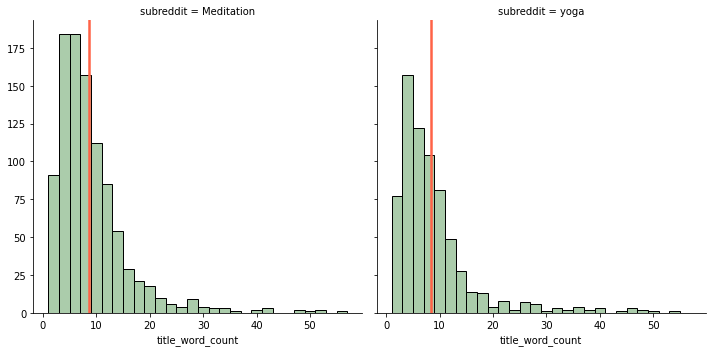

In [42]:
g3 = sns.displot(
    combined_cleaned, x="title_word_count", col="subreddit",color='darkseagreen',
    binwidth=2, height=5, facet_kws=dict(margin_titles=True),
)

def specs(x, **kwargs):
    plt.axvline(x.mean(), c='tomato', ls='-', lw=2.5)
    
g3.map(specs,'title_word_count')

In [73]:
print('Mean number of words in title for r/Meditation: ' + str(round((combined_cleaned['title_word_count'].loc[combined_cleaned['subreddit']=='Meditation']).mean(),2)))
print('Mean number of words in title for r/yoga: ' + str(round((combined_cleaned['title_word_count'].loc[combined_cleaned['subreddit']=='yoga']).mean(),2)))

Mean number of words in title for r/Meditation: 8.59
Mean number of words in title for r/yoga: 8.38


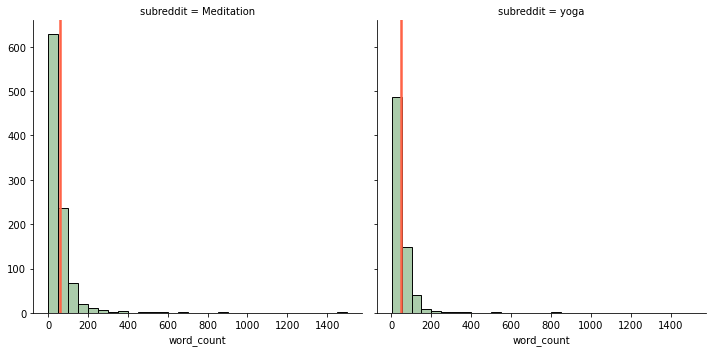

In [44]:
g4 = sns.displot(
    combined_cleaned, x="word_count", col="subreddit",color='darkseagreen',
    binwidth=50, height=5, facet_kws=dict(margin_titles=True),
)

def specs(x, **kwargs):
    plt.axvline(x.mean(), c='tomato', ls='-', lw=2.5)
    
g4.map(specs,'word_count')

In [45]:
print('Mean number of words in r/Meditation: ' + str(round((combined_cleaned['word_count'].loc[combined_cleaned['subreddit']=='Meditation']).mean(),2)))
print('Mean number of words in r/yoga: ' + str(round((combined_cleaned['word_count'].loc[combined_cleaned['subreddit']=='yoga']).mean(),2)))

Mean number of words in r/Meditation: 58.06
Mean number of words in r/yoga: 47.18


The title and post lengths are right-skewed with majority of posts having less than 100 words.

## Score & Upvote Ratio
reference: https://www.reddit.com/r/TheoryOfReddit/comments/dcz833/a_simple_way_to_estimate_up_and_down_votes/

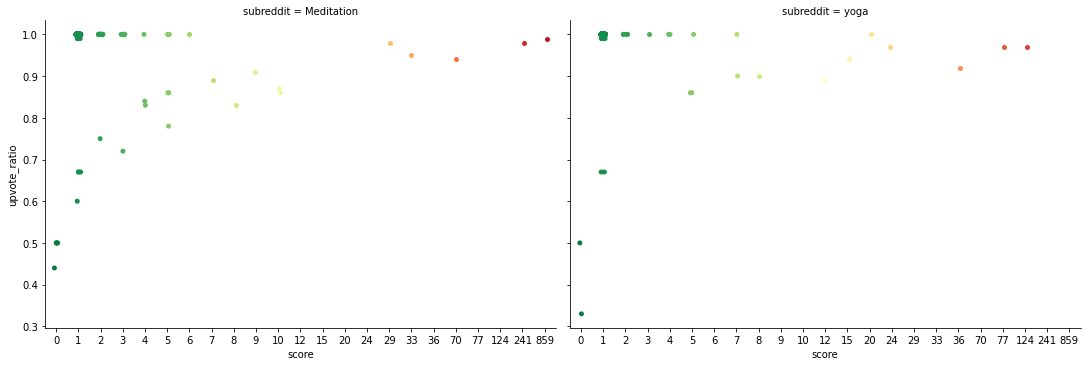

In [46]:
g1 = sns.catplot(x="score", y="upvote_ratio", palette='RdYlGn_r',
                col="subreddit", data=combined_cleaned,height=5, aspect=1.5)

We can observe that most posts had a positive rating and affirmed by the community that the post is relevant. We can observe some posts that have much higher upvotes. These can be interpreted to be very popular posts.

## Outliers

In considering what posts may be considered outliers, we check the validity of the submissions (e.g. if the post is relevant to the subject).

Although the post lengths are *right-skewed*, longer posts will still be kept. This is because under the NLP modelling, length of posts should not affect the model but whether the word tokens do appear across multiple posts.

Below, we will consider if extreme scores/upvote ratios should be considered as outliers

In [47]:
# Finding posts with negative scores
combined_cleaned['score'].loc[combined_cleaned['score'] < 0].value_counts()

Series([], Name: score, dtype: int64)

In [48]:
# Number of posts with higer upvotes
combined_cleaned[['subreddit','score']].loc[(combined_cleaned['score'] > 25)].value_counts().sort_index()

subreddit   score
Meditation  29       1
            33       1
            70       1
            241      1
            859      1
yoga        36       1
            77       1
            124      1
dtype: int64

In [49]:
combined_cleaned[['title','selftext','score','num_comments']].loc[(combined_cleaned['score'] == 29)|
                                                                  (combined_cleaned['score'] == 33)|
                                                                  (combined_cleaned['score'] == 70)|
                                                                  (combined_cleaned['score'] == 241)|
                                                                  (combined_cleaned['score'] == 859)|
                                                                  (combined_cleaned['score'] == 36)|
                                                                  (combined_cleaned['score'] == 77)|
                                                                  (combined_cleaned['score'] == 124)]

,title,selftext,score,num_comments
1152,30 days / 30 hours of meditation. I did it !,"Just wanna share my experience with you guys. I'll try to keep it short.\n\nIn November I was feeling kind of lethargic. Low energy and low motivation to do things. I'm a nervous type of person and I'm used to have racing thoughts even at night. I previously did something like this but it was more than a year and a half ago. I honestly felt great at that time and decided to stop for obscure reason I don't even remember lol\n\nSo I thought, why not, let's give it another shot and see how it goes.\n\nEveryday I would meditate after work around 5-6pm. Did both sitting and lied down meditations. 1 hour everyday.\n\nOne thing that I see that is common among meditators is that you often don't feel like you get any benefits from the practice anymore. But when you stop, that is when you realise how much it had a heavy impact on your general health and emotional balance. \n\nLong story short : I can sleep again. I used to be anxious about not sleeping thus not falling asleep. Even after the first few days I started not even thinking about falling asleep. I would just fall asleep. I still wake up in the middle of the night but I quickly fall asleep again, whereas before I'd find it really hard to do it.\n\nI digest food way better, my emotional balance is great and all of my relationships got improved. 90% of my doubts, fear and overthinking is now gone. The 10% that remains is still kicking my ass sometimes but I can manage it and go on with my day. I don't feel like I'm fighting against myself anymore.\n\nI'm also way more focused and I don't spend a lot of time doing useles stuff like watching too many youtube videos or playing video games when I'm supposed to be an adult. Meditation helped me see clearly again, and see what is good for my health and what isn't. \n\nBut the best thing I want to share with you is that throughout these 30 days I really learned that I can heal myself. You hear everyone telling you that ""you have the answers inside of you"" and this is true. \n\nI would meditate and I had very intense dreams where I would live again traumatic situations. I remember waking up after one of them and thinking to myself ""this is gone, I'll be able to move on now."" \n\nAnd so I did.\n\nIn the past I tried many different things to get better and find healing. But meditation was all I needed. Suffering is not gone. Anxious thoughts are still there. But I've learned that meditation is not about emptying your mind but learning to live with yourself. Your mind is like your roomate. You can either be fighting against him or be at peace with him. No matter what you'll do he'll still be here, so why not loving him?",241,24
1183,The Win Hof method,Has anyone tried the Win Hof method of breathing technique?,70,104
1205,Spontaneous World Meditation: Who’s up for it?,"This could go nowhere. \n\nOr we could turn it into something truly beautiful during a hectic end to the year. \n\nI know we have the yearly world meditation day every May; but I can imagine the positivity that would come out of a Reddit, social media fuelled meditation day…\n\nNo one needs to take credit. \n\nCan we just collectively boost it? \n\nMonday 13th December. \n\nJust take some time specifically on Monday to add that little extra effort in your meditation. \n\nLet’s amplify the positive world consciousness ✨",29,10
1231,Some Reflections on ADHD and Meditation,"I'll preface by acknowledging this post may be fairly niche and apply to only a small percentage of this subreddit. Nevertheless, I felt like sharing some insights I've come to regarding meditation and its impact on my ADHD. \n\nI thought Mindfulness and meditation would be my panacea for ADHD. However, as is expected, this was not the case. Thankfully through bouts of therapy, various medications, and meditation I have grown to understand myself and my relationship to this disorder in very interesting ways. \n\nWhat I f

In [50]:
# Number of posts with more downvotes than upvotes or tied
combined_cleaned[['subreddit','upvote_ratio']].loc[combined_cleaned['upvote_ratio'] <= 0.5].value_counts().sort_index()

subreddit   upvote_ratio
Meditation  0.44            1
            0.50            4
yoga        0.33            1
            0.50            1
dtype: int64

Scores and upvote ratio vary day to day. Given that the number of posts with high upvotes were mostly due to it being a popular post for discussion (as seen in the number of comments), these posts will not be considered outliers.

## Number of comments

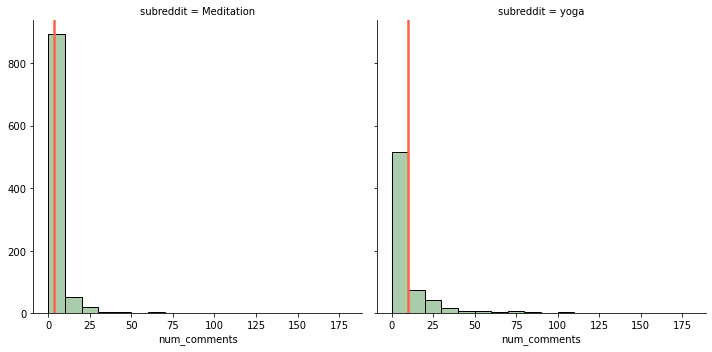

In [51]:
g2 = sns.displot(
    combined_cleaned, x="num_comments", col="subreddit",color='darkseagreen',
    binwidth=10, height=5, facet_kws=dict(margin_titles=True),
)

def specs(x, **kwargs):
    plt.axvline(x.mean(), c='tomato', ls='-', lw=2.5)
    
g2.map(specs,'num_comments')

In [52]:
print('Mean number of comments in r/Meditation: ' + str(round((combined_cleaned['num_comments'].loc[combined_cleaned['subreddit']=='Meditation']).mean(),2)))
print('Mean number of comments in r/yoga: ' + str(round((combined_cleaned['num_comments'].loc[combined_cleaned['subreddit']=='yoga']).mean(),2)))

Mean number of comments in r/Meditation: 3.32
Mean number of comments in r/yoga: 9.74


The average number of comments for yoga posts were three times higher than meditation. This shows that there is higher discussion and participation among the yoga subredditers.

## Top Words

In [53]:
def plot_wordcloud(text_df):
    
    words = text_df.values 
    
    wordcloud = WordCloud(background_color='whitesmoke',
                stopwords=set(STOPWORDS),
                max_words=100,
                max_font_size=40,
                colormap='Set2',
                scale=3,
                random_state=1).generate(str(words))

    fig = plt.figure(1, figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

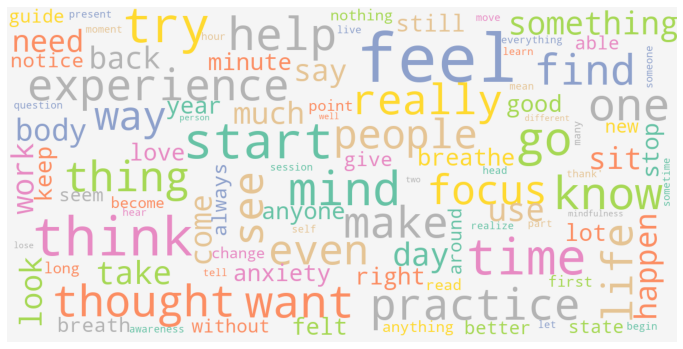

In [54]:
plot_wordcloud(combined_cleaned['text'].loc[combined_cleaned['subreddit']=='Meditation'])

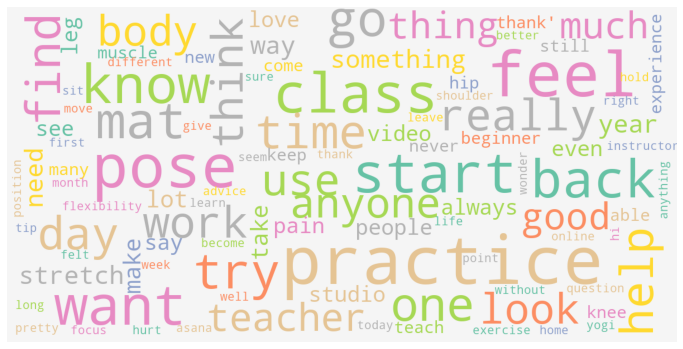

In [55]:
plot_wordcloud(combined_cleaned['text'].loc[combined_cleaned['subreddit']=='yoga'])

Monograms reveal top words for yoga to be:
- practice
- pose
- feel
- class
- start

and for Meditation: 
- feel
- think
- practice
- start
- time

We can note several similar words between both subreddits which could highlight the possibility of reaching out to meditation seekers to seek yoga as a potential self-care tool.

In [56]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [57]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,palette='Set2')

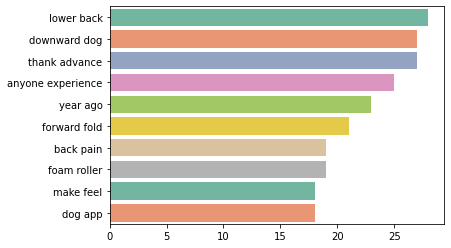

In [58]:
plot_top_ngrams_barchart(combined_cleaned['text'].loc[combined_cleaned['subreddit']=='yoga'],2)

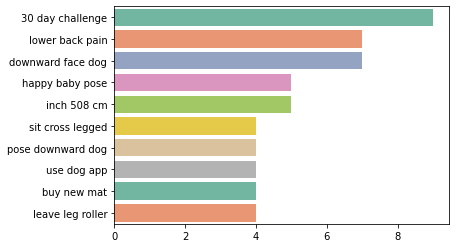

In [59]:
plot_top_ngrams_barchart(combined_cleaned['text'].loc[combined_cleaned['subreddit']=='yoga'],3)

Top bigrams and trigrams for r/yoga reveal posts on 
1. types of yoga poses (e.g. 'downward dog, 'forward fold', 'sit crossed legged), 
2. exercise equipment (e.g. foam roller, mat)
3. experiences (30 day challenge)

These could be possible keywords to tailor advertisements on.

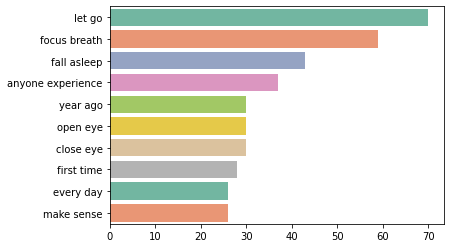

In [60]:
plot_top_ngrams_barchart(combined_cleaned['text'].loc[combined_cleaned['subreddit']=='Meditation'],2)

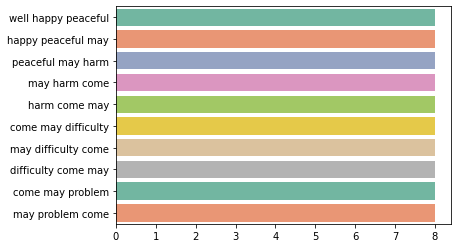

In [61]:
plot_top_ngrams_barchart(combined_cleaned['text'].loc[combined_cleaned['subreddit']=='Meditation'],3)

On the otherhand, ngrams for r/Meditation aren't too straightforward but they mostly reference 
1. bigrams: breath, eyes and letting go
2. trigrams: feelings (happy, peaceful)
3. trigrams: things to come? (problem, harm, difficulty)

Trigrams occurred on a much lower frequency hence, we need not look too much into them.

# Annex
## Data Dictionary
| Feature             | Type    | Description                                                                                          |
|---------------------|---------|------------------------------------------------------------------------------------------------------|
| subreddit           | object  | The subreddit the submission belongs to. In this dataset, it would either be r/yoga or r/Meditation. |
| title               | object  | The title of the submission.                                                                         |
| selftext            | object  | The submissions’ selftext.                                                                           |
| is_self             | boolean | Whether or not the submission is a selfpost (i.e. text-only).                                        |
| num_comments        | integer | The number of comments on the submission.                                                            |
| created_utc         | integer | Time the submission was created, represented in Unix Time.                                           |
| created             | object  | Time the submission was created, represented in YYYY-MM-DD HH:MM:SS                                  |
| removed_by_category | object  | Denotes who the submission was removed by.                                                           |
| banned_by           | object  | Denotes who the submission was banned by.                                                            |
| author              | object  | Redditor's alias.                                                                                    |
| url                 | object  | URL of submission.                                                                                   |
| score               | integer | The net upvote count.                                                                                |
| upvote_ratio        | float   | The percentage of upvotes from all votes on the submission.                                          |
| text                | object  | Concatenated 'title' and 'selftext'.                                                                 |
| stopwords           | integer | Number of stopwords in submission.                                                                   |
| punctuation         | integer | Number of punctuation in submission.                                                                 |
| hastags             | integer | Number of hashtags in submission.                                                                    |
| numerics            | integer | Number of numerical characters in submission.                                                        |
| upper               | integer | Number of uppercase words in submission.                                                             |
| title_word_count    | integer | Number of words in 'title'.                                                                          |
| word_count          | integer | Number of words in 'text'.                                                                           |
| char_count          | integer | Number of characters in 'text'.                                                                      |
| avg_word            | float   | Average word length of words in 'text'.                                                              |